In [1]:
import os
import bye_cycle
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle

In [2]:
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
# Disabling GPU
RUN_ON_GPU = True
if not RUN_ON_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
dat = []
for file in os.listdir('CACHED_DATA/'):
    if file.startswith("cell"):
        with open(f'CACHED_DATA/{file}', 'rb') as f:
            cell_data = np.array(pickle.load(f))[0]
        dat.append(cell_data)
print('CACHED data is loaded.')

CACHED data is loaded.


In [63]:
len(dat[8])

2

In [71]:
import random
random.seed(0)
indices = list(range(len(dat)))
random.shuffle(indices)
train_size = 0.9
val_size = 0.09
N_train = int(train_size *len(dat))
N_val = int(val_size *len(dat))
train_dat = dat[:N_train]
# train_indices = random.sample(range(len(dat)), N_train)
test_dat = dat[N_train:]
val_dat = test_dat[:N_val]
test_dat = test_dat[N_val:]

# val_indices = random.sample(list(range(len(dat))).pop(train_indices), N_val)
# N_test = len(dat) - N_train - N_val

In [66]:
# data_prep
def prep_ml_data(dat, cycle_numbers=20):
    features = np.empty([0, cycle_numbers,100, 3])
    labels = np.empty([0, cycle_numbers])
    print('Generating features and labels. Skipping cells with cycles lower than 50.')
    for j,d in enumerate(tqdm(dat)):
        if not len(d) < 50:
            n = d.shape[0]//cycle_numbers
            cell_features = []
            cell_labels = []
            for i in range(n-1):
                cell_features.append(d[cycle_numbers*i:cycle_numbers*(i+1), :, :3])
                cell_labels.append(d[cycle_numbers*(i+1):cycle_numbers*(i+2), 0, -1])
#             print(np.array(cell_features).shape, j)
            features = np.append(features, np.array(cell_features), axis=0)
            labels = np.append(labels, np.array(cell_labels), axis=0)
        else:
            print(f'Cell {j} has only {len(d)} cycles. Skipping!')
    return features, labels

In [67]:
train_features, train_labels = prep_ml_data(train_dat)

Generating features and labels. Skipping cells with cycles lower than 50.


  6%|▌         | 19/339 [00:00<00:01, 182.78it/s]

Cell 8 has only 2 cycles. Skipping!


 11%|█         | 38/339 [00:00<00:06, 49.11it/s] 

Cell 41 has only 2 cycles. Skipping!


 39%|███▉      | 133/339 [00:11<00:28,  7.29it/s]

Cell 131 has only 48 cycles. Skipping!


 56%|█████▋    | 191/339 [00:24<00:39,  3.78it/s]

Cell 191 has only 2 cycles. Skipping!


100%|██████████| 339/339 [01:18<00:00,  4.34it/s]


In [68]:
val_features, val_labels = prep_ml_data(val_dat)

Generating features and labels. Skipping cells with cycles lower than 50.


100%|██████████| 33/33 [00:00<00:00, 51.33it/s] 


In [69]:
test_features, test_labels = prep_ml_data(test_dat)

Generating features and labels. Skipping cells with cycles lower than 50.


100%|██████████| 5/5 [00:00<00:00, 129.55it/s]


In [72]:
def standardize(inputs):
    fstd = np.std(inputs, axis=0)
    fmean = np.mean(inputs, axis=0)
    std_features = (inputs - fmean) / fstd
    return std_features
std_train_features = standardize(train_features)
std_test_features = standardize(test_features)
std_val_features = standardize(val_features)

In [73]:
from dataclasses import dataclass
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(train_labels), 
                batch_size=512, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

In [75]:
# [:,:,:2]
np.random.seed(0)
i = np.arange(len(train_features))
np.random.shuffle(i)
train_data = tf.data.Dataset.from_tensor_slices((std_train_features[i], train_labels[i])).batch(config.batch_size)
i = np.arange(len(val_features))
val_data = tf.data.Dataset.from_tensor_slices((std_val_features[i], val_labels[i])).batch(config.batch_size)
i = np.arange(len(test_features))
test_data = tf.data.Dataset.from_tensor_slices((std_test_features[i], test_labels[i])).batch(config.batch_size)
N = len(dat)
C = std_train_features.shape[1]
T = std_train_features.shape[2]
L = std_train_features.shape[-1]

In [93]:
std_train_features.shape

(23103, 20, 100, 3)

In [107]:
def build_model(C, T, L, cycle_numbers=20):
    inputs = tf.keras.Input(shape=(C, T, L))
    print(f'input: {inputs.shape}')
    conv_1d_layer = tf.keras.layers.Conv1D(16, 100)
    blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
    x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(5, 3))(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     x = tf.keras.layers.Reshape((100, 64))(x)
    print(f'output CNN 1: {x.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
    print(x.shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
#     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
#                                     output_dim=config.embedding_dim,
#                                     mask_zero=True)(inputs)
    yhat = tf.keras.layers.Dense(cycle_numbers)(x)
    model = tf.keras.Model(inputs=[inputs], outputs=yhat)
    return model
tf.keras.backend.clear_session()
model = build_model(C, T, L)
opt = tf.optimizers.Adam(1e-3)
model.compile(
  opt,
  loss='mean_squared_error')
model.summary()

input: (None, 20, 100, 3)
output CNN 1: (None, 20, 16)
(None, 20, 16)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 100, 3)]      0         
                                                                 
 time_distributed (TimeDistr  (None, 20, 1, 16)        4816      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16)           0         
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                10

In [108]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)],
# #         tf.keras.callbacks.LambdaCallback(
# #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# #         ),
#         ,
    epochs=150)

Epoch 1/150
46/46 [==============================] - 5s 47ms/step - loss: 3.4855 - val_loss: 2.8131 - lr: 0.0010
Epoch 2/150
46/46 [==============================] - 1s 26ms/step - loss: 1.2137 - val_loss: 0.9086 - lr: 0.0010
Epoch 3/150
46/46 [==============================] - 1s 26ms/step - loss: 0.3017 - val_loss: 0.5406 - lr: 0.0010
Epoch 4/150
46/46 [==============================] - 1s 25ms/step - loss: 0.1886 - val_loss: 0.5001 - lr: 0.0010
Epoch 5/150
46/46 [==============================] - 1s 25ms/step - loss: 0.1655 - val_loss: 0.5114 - lr: 0.0010
Epoch 6/150
46/46 [==============================] - 1s 25ms/step - loss: 0.1537 - val_loss: 0.5676 - lr: 0.0010
Epoch 7/150
46/46 [==============================] - 1s 25ms/step - loss: 0.1442 - val_loss: 0.5427 - lr: 0.0010
Epoch 8/150
46/46 [==============================] - 1s 25ms/step - loss: 0.1399 - val_loss: 0.4674 - lr: 0.0010
Epoch 9/150
46/46 [==============================] - 1s 25ms/step - loss: 0.1369 - val_loss: 0.5

Text(0.5, 0, 'Epochs')

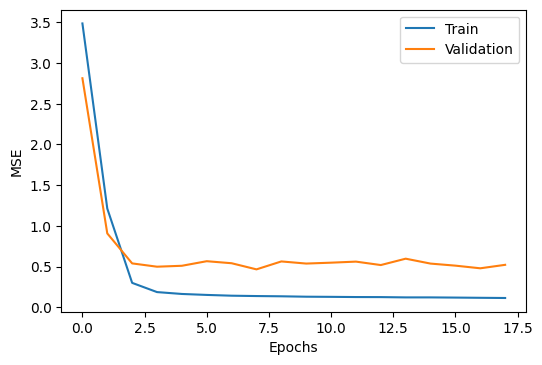

In [109]:
import matplotlib.pyplot as plt
plt.figure(dpi=100)
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')